In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [10]:
data = pd.read_csv('Portland_riders_data.csv', index_col=0, header=0, parse_dates=True).squeeze('columns')
data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 102 entries, 1960-01-01 to 1968-06-01
Series name: Riders
Non-Null Count  Dtype
--------------  -----
102 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


In [11]:
data.head()

Month
1960-01-01    648
1960-02-01    646
1960-03-01    639
1960-04-01    654
1960-05-01    630
Name: Riders, dtype: int64

In [12]:
# Statistical desription of data
data.describe()

count     102.000000
mean     1091.401961
std       270.756486
min       613.000000
25%       859.500000
50%      1127.000000
75%      1295.750000
max      1558.000000
Name: Riders, dtype: float64

Text(0, 0.5, 'Number of riders')

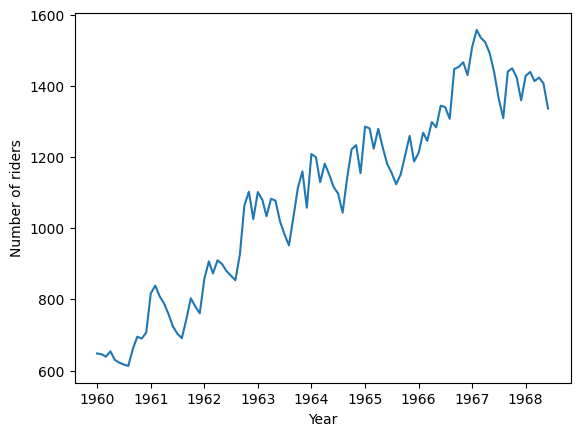

In [13]:
plt.plot(data)
plt.xlabel('Year')
plt.ylabel('Number of riders')

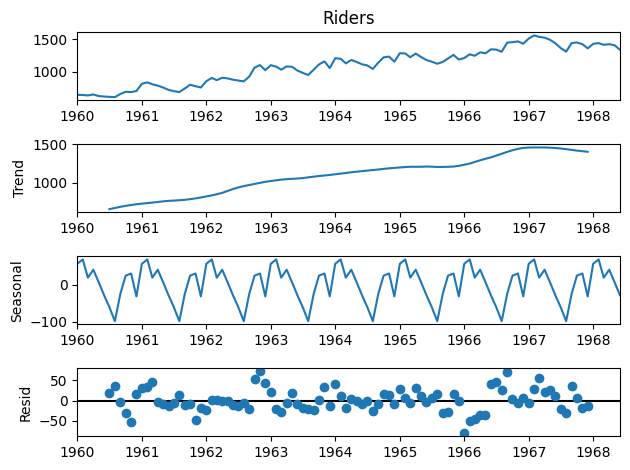

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(data)
res.plot()
plt.show()

##### The period is 12 months. Decomposition not successful as the residue has large variations with time. So we will do multiplicative decomposition

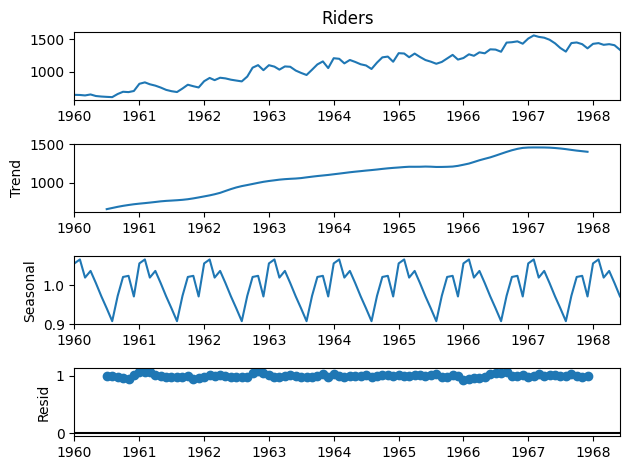

In [15]:
res = seasonal_decompose(data, model = 'multiplicative')
res.plot()
plt.show()

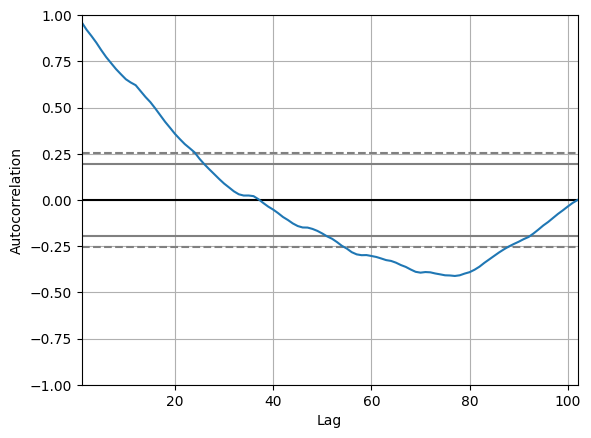

In [16]:
#Plotting the autocorrelation function of the series
datalog = np.log(data)
pd.plotting.autocorrelation_plot(datalog)
plt.show()

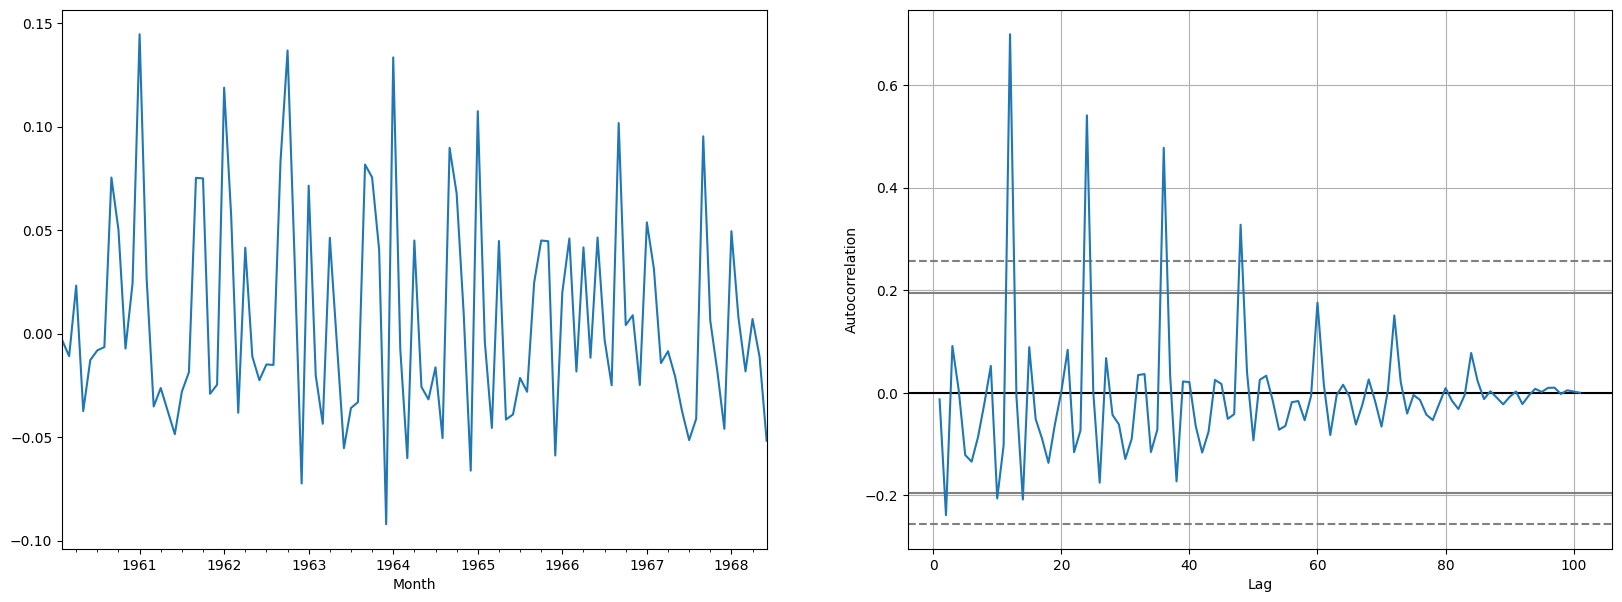

In [17]:
# To estimate the  d and  D  parameters of the model  SARIMA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7)) 

datalog_1 = datalog.diff().dropna() 

datalog_1.plot(ax = ax1) 
pd.plotting.autocorrelation_plot(datalog_1, ax = ax2)
plt.show()

##### Autocorrelation curve tends towards 0 but has seasonal peaks, which one can confirm from the graph on left

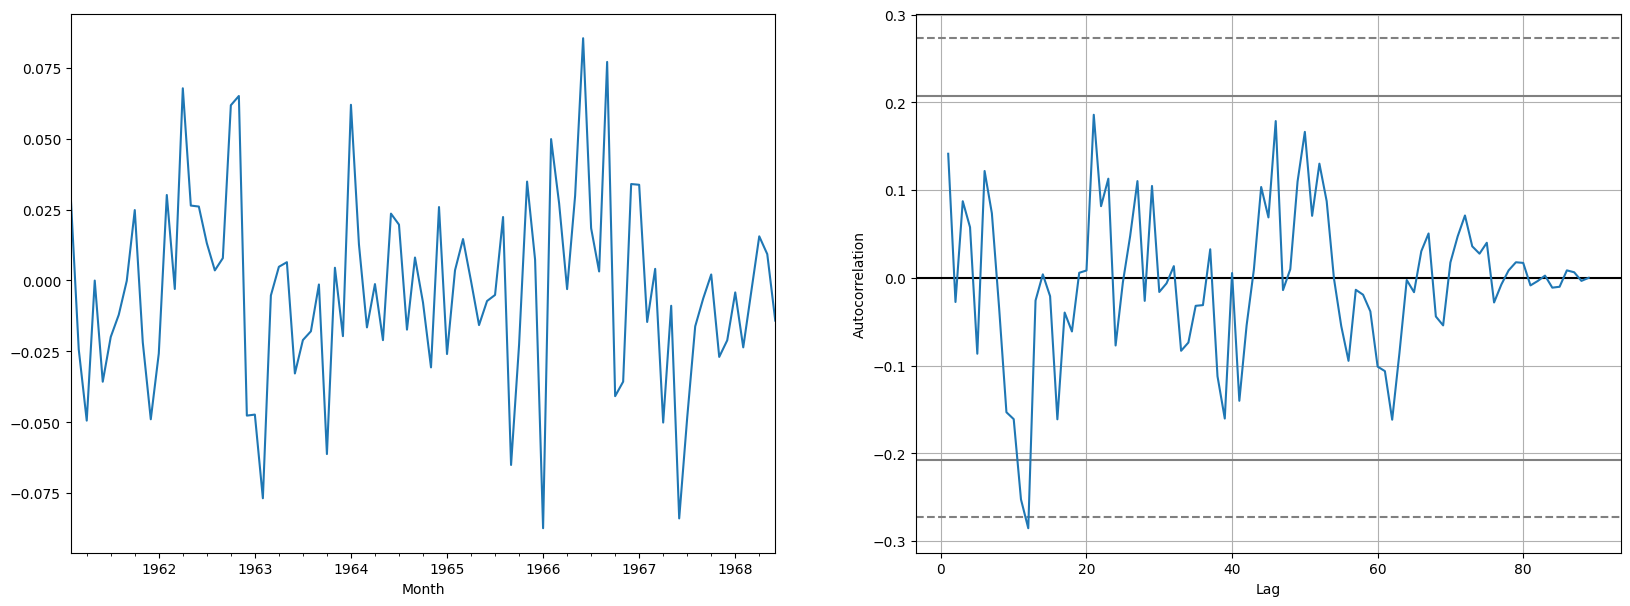

In [18]:
#Therefore, deseasonalizing it according to period 12

datalog_2 = datalog_1.diff(periods = 12).dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
datalog_2.plot(ax = ax1)
pd.plotting.autocorrelation_plot(datalog_2, ax = ax2)
plt.show()


In [19]:
  # Now the peaks are irregular
# Here we apply ADF test to check whether the series is now stationary or not
_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(datalog_2)
print('p value is', p_value)

p value is 1.4525703195873377e-12


##### Since p-value is less than 5%, therefore we reject the hypothesis, and assume the time series as stationary
######  d and D parameters of SARIMA: d=1 and D=1

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


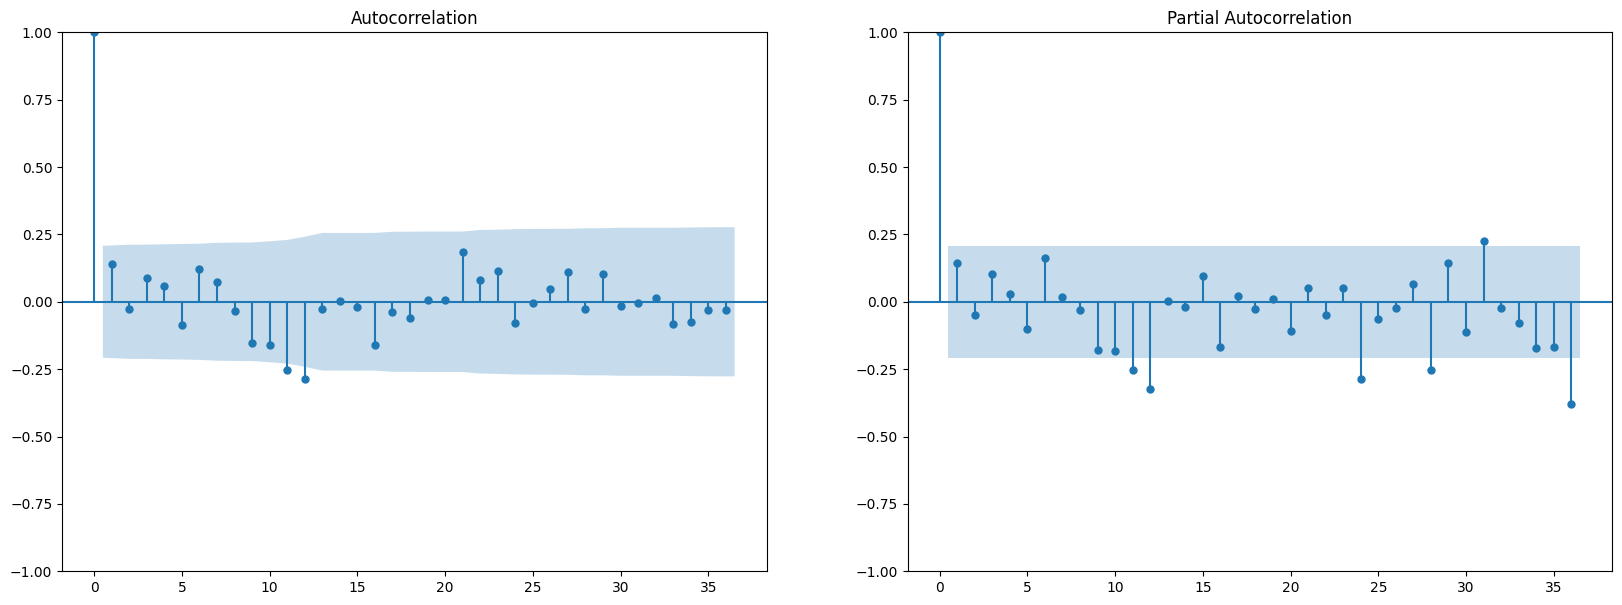

In [20]:
# For plotting autocorrelation and partial autocorrelation curves and estimate p,P, q, Q for SARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(datalog_2, lags = 36, ax=ax1)
plot_pacf(datalog_2, lags = 36, ax=ax2)
plt.show()

In [21]:
## Using the SARIMAX function to estimate the best possible model for this series. 
model=sm.tsa.SARIMAX(datalog,order=(0,1,0),seasonal_order=(0,1,1,12))
sarima=model.fit()
print(sarima.summary())

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                               Riders   No. Observations:                  102
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 180.755
Date:                              Fri, 28 Oct 2022   AIC                           -357.510
Time:                                      19:07:59   BIC                           -352.533
Sample:                                  01-01-1960   HQIC                          -355.504
                                       - 06-01-1968                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.5034      0.120     -4.193      0.000      -0.739      -0.268
sigma2         0.00

##### Ljung-Box and Jarque-Bera Prob show residue is a white noise as Prob is > 5%

In [22]:
## prediction for the 12 months following the last available measurement
import datetime
pred = np.exp(sarima.predict(102,113))
pred = pred.astype(int)
pred

1968-07-01    1295
1968-08-01    1250
1968-09-01    1364
1968-10-01    1391
1968-11-01    1392
1968-12-01    1331
1969-01-01    1406
1969-02-01    1431
1969-03-01    1401
1969-04-01    1418
1969-05-01    1395
1969-06-01    1348
Freq: MS, Name: predicted_mean, dtype: int32

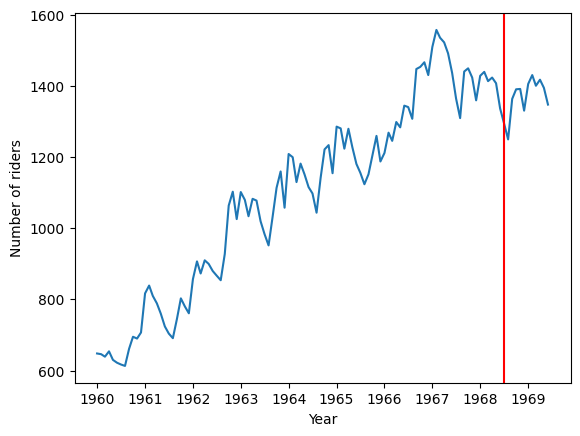

In [26]:
datapred = pd.concat([data, pred])
plt.plot(datapred)
plt.axvline(x= datetime.date(1968,7,1), color='red')
plt.xlabel('Year')
plt.ylabel('Number of riders')
plt.show();

In [27]:
true = pd.read_csv('Actual_riders.csv', header=0, parse_dates=[0],
                      index_col=0).squeeze('columns')

In [28]:
true.head(), true.index

(Month
 1968-07-01    1258
 1968-08-01    1214
 1968-09-01    1326
 1968-10-01    1417
 1968-11-01    1417
 Name: Riders, dtype: int64,
 DatetimeIndex(['1968-07-01', '1968-08-01', '1968-09-01', '1968-10-01',
                '1968-11-01', '1968-12-01', '1969-01-01', '1969-02-01',
                '1969-03-01', '1969-04-01', '1969-05-01', '1969-06-01'],
               dtype='datetime64[ns]', name='Month', freq=None))

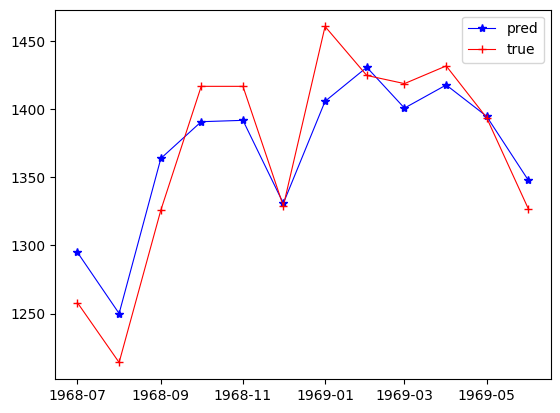

In [29]:
plt.plot(pred, 'b-*', linewidth = 0.8, label= 'pred')
plt.plot(true, 'r-+', linewidth = 0.8, label= 'true')
plt.legend()
plt.show()

In [30]:
diff = abs(pred-true)
print ('The relative mean error is', round(np.mean(diff)/np.mean(true)*100, 3), '%')

The relative mean error is 1.699 %
